# Data Extraction via API

In [4]:
from cryptocompare.blockchain_data import get_blockchain_data
from cryptocompare.ohlcv import get_ohlcv
import pandas as pd

fsyms = ['ETH', 'BTC', 'DOGE', 'MATIC']

# Collect data
ohlcv_data = pd.DataFrame()
blockchain_data = pd.DataFrame()

for fsym in fsyms:
    ohlcv_data_temp = get_ohlcv(fsym)
    ohlcv_data_temp['symbol'] = fsym
    ohlcv_data = pd.concat([ohlcv_data, ohlcv_data_temp])

    blockchain_data_temp = get_blockchain_data(fsym)
    blockchain_data = pd.concat([blockchain_data, blockchain_data_temp])

ohlcv_data = ohlcv_data.reset_index().drop(columns=['index'])

# Save into csv
blockchain_data.to_csv('data/blockchain_data.csv')
ohlcv_data.to_csv('data/ohlcv_data.csv')


---- Extracting price data for ETH ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-12 00:00:00 To 2022-08-05 01:00:00
Run number: 2 

Response received
Date range: From 2011-08-23 01:00:00 To 2017-02-12 00:00:00
No more data received. Terminating the loop at run 2 

---- Extracting blockchain data for ETH ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-12 00:00:00 To 2022-08-05 01:00:00
Run number: 2 

Response received
Date range: From 2011-08-23 01:00:00 To 2017-02-12 00:00:00
Run number: 3 

No more data received. Terminating the loop at run 3 

---- Extracting price data for BTC ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-12 00:00:00 To 2022-08-05 01:00:00
Run number: 2 

Response received
Date range: From 2011-08-23 01:00:00 To 2017-02-12 00:00:00
Run number: 3 

Response received
Date range: From 2006-03-02 00:00:00 To 2011-08-23 01:00:00
No more data received. Terminating the loop at run 3 

---- Extracting bl

# Feature Engineering and Feature Selection

## Load data from CSV file

In [1]:
import pandas as pd

blockchain_data = pd.read_csv('data/blockchain_data.csv')
blockchain_data = blockchain_data.drop(columns=['Unnamed: 0', 'index', 'id'])
blockchain_data = blockchain_data.drop_duplicates(subset=['date', 'symbol'], keep='first')

ohlcv_data = pd.read_csv('data/ohlcv_data.csv')
ohlcv_data = ohlcv_data.drop(columns=['Unnamed: 0', 'level_0', 'time'])
ohlcv_data = ohlcv_data.drop_duplicates(subset=['date', 'symbol'], keep='first')

google_trends_eth = pd.read_csv('data/Google_Trends_historical_interest.csv')


# # Merge ohlcv and blockhain data
# df = pd.merge(ohlcv_data, blockchain_data, how='inner', on=['date', 'symbol'])


## Build Technical indicators and Target variables

In [2]:
fsyms = ['ETH', 'BTC', 'DOGE', 'MATIC']

from data_engineering import build_features_TA, build_target

features = build_features_TA(ohlcv_data, fsyms)
outcomes = build_target(ohlcv_data, fsyms)

In [ ]:
# Statistical characteristics of features



# Check for duplicates
# features[features.duplicated(subset=['date', 'symbol'], keep=False)]


## Data pre-processing

In [3]:
import datetime

features_eth = features[features['symbol'] == 'ETH']
features_eth = features_eth.drop(columns=['symbol'])
features_eth['date'] = (features_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
                        )

outcomes_eth = outcomes[outcomes['symbol'] == 'ETH']
outcomes_eth['date'] = outcomes_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )


features_eth_blockchain = blockchain_data[blockchain_data['symbol'] == 'ETH']

features_eth_blockchain = features_eth_blockchain.drop(columns=['symbol', 'time'])
features_eth_blockchain['date'] = features_eth_blockchain.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )

google_trends_eth['date'] = google_trends_eth['date'].apply( lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') )

google_trends_eth = google_trends_eth.set_index('date').resample('D').sum()
google_trends_eth = google_trends_eth.reset_index().drop(columns='isPartial')

features_eth = features_eth.set_index('date')
features_eth_blockchain = features_eth_blockchain.set_index('date')
google_trends_eth = google_trends_eth.set_index('date')
outcomes_eth = outcomes_eth.set_index('date')


# nonnull_dates = outcomes_eth.merge(features_eth, how='inner', on='date').dropna().date
nonnull_index = outcomes_eth.merge(features_eth, how='inner', on='date').dropna().index

features_eth = features_eth.loc[nonnull_index, :]
features_eth_blockchain = features_eth_blockchain.loc[nonnull_index, :]
google_trends_eth = google_trends_eth.loc[nonnull_index, :]
outcomes_eth = outcomes_eth.loc[nonnull_index, :]

# Reset indices
features_eth = features_eth.reset_index()
features_eth_blockchain = features_eth_blockchain.reset_index()
google_trends_eth = google_trends_eth.reset_index()
outcomes_eth = outcomes_eth.reset_index()


print(features_eth.shape, features_eth_blockchain.shape, outcomes_eth.shape, google_trends_eth.shape)

C:\Users\yesbo\AppData\Local\Temp\ipykernel_10820\2912139076.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcomes_eth['date'] = outcomes_eth.date.apply(


(2489, 22) (2489, 15) (2489, 10) (2489, 3)


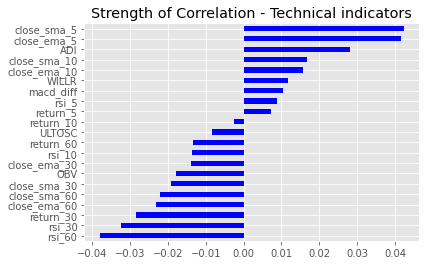

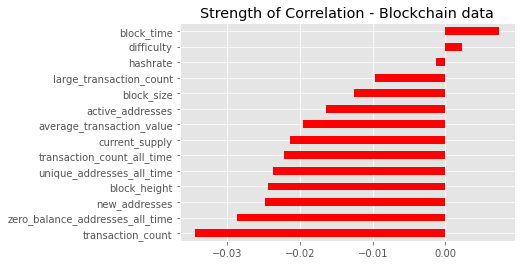

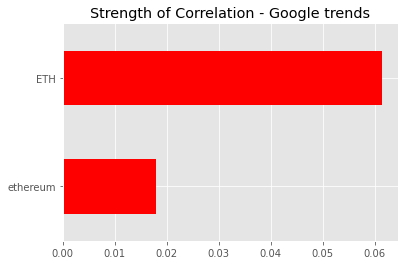

In [60]:
import matplotlib.pyplot as plt

# Correlation strength
plt.style.use('ggplot')

# plt.figure(figsize=(15,10))

corr = features_eth.corrwith(outcomes_eth['direction_1'])
corr.sort_values().plot.barh(color = 'blue', title = 'Strength of Correlation - Technical indicators')
plt.show()


plt.style.use('ggplot')
corr = features_eth_blockchain.corrwith(outcomes_eth['direction_1'])
corr.sort_values().plot.barh(color = 'red', title = 'Strength of Correlation - Blockchain data')
plt.show()

plt.style.use('ggplot')
corr = google_trends_eth.corrwith(outcomes_eth['direction_1'])
corr.sort_values().plot.barh(color = 'red', title = 'Strength of Correlation - Google trends')
plt.show()

# **Prediction models**

## *Construct datasets*

In [4]:
dataset_1 = features_eth
dataset_2 = features_eth_blockchain
dataset_3 = google_trends_eth
dataset_4 = features_eth.merge(features_eth_blockchain)
dataset_5 = dataset_4.merge(google_trends_eth)

### *Run Predictions*

In [8]:
from xgboost import XGBClassifier
from run_predictions import fit_predict, evaluate_model

predictions = fit_predict(XGBClassifier(), dataset_2, outcomes_eth['direction_1'], train_period=60, test_period=14)

y_true = outcomes_eth.set_index('date')['direction_1'].loc[predictions.index]

metrics = evaluate_model(y_true=y_true, y_pred=predictions)



Train period: 2015-10-06 - 2015-12-05 , Test period 2015-12-06 - 2015-12-20 # train records 60 , # test records 14
Train period: 2015-10-20 - 2015-12-19 , Test period 2015-12-20 - 2016-01-03 # train records 60 , # test records 14
Train period: 2015-11-03 - 2016-01-02 , Test period 2016-01-03 - 2016-01-17 # train records 60 , # test records 14
Train period: 2015-11-17 - 2016-01-16 , Test period 2016-01-17 - 2016-01-31 # train records 60 , # test records 14
Train period: 2015-12-01 - 2016-01-30 , Test period 2016-01-31 - 2016-02-14 # train records 60 , # test records 14
Train period: 2015-12-15 - 2016-02-13 , Test period 2016-02-14 - 2016-02-28 # train records 60 , # test records 14
Train period: 2015-12-29 - 2016-02-27 , Test period 2016-02-28 - 2016-03-13 # train records 60 , # test records 14
Train period: 2016-01-12 - 2016-03-12 , Test period 2016-03-13 - 2016-03-27 # train records 60 , # test records 14
Train period: 2016-01-26 - 2016-03-26 , Test period 2016-03-27 - 2016-04-10 # tr

d:\UNI\Dissertation\simulations\run_predictions.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  preds = pd.Series(index=X.loc[test_data_indices]['date'])


In [9]:
metrics

{'accuracy': 0.5115606936416185,
 'precision': 0.4973214285714286,
 'f1_score': 0.48498040922942975}

# Archive (Just in case)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense


standard_scaler = StandardScaler()

split_point = int(0.80*len(features_eth))

features = features_eth_blockchain.merge(features_eth, on='date')
target = outcomes_eth['direction_5']
# train_dataset = features_eth.join(outcomes_eth['direction_1']).iloc[:split_point,:]

X_train = features.iloc[:split_point, :]
y_train = target.iloc[:split_point]

X_test = features.iloc[split_point:, :] 
y_test = target.iloc[split_point:]

# Transform training dataset
X_train = standard_scaler.fit_transform(X_train)

# Transform test dataset
X_test = standard_scaler.fit_transform(X_test)

# model = LogisticRegression()
model = svm.SVC(kernel='linear', C=1000)


model.fit(X=X_train, y=y_train)

print('Accuracy in-sample: {}'.format(model.score(X=X_train, y=y_train)))
print('Accuracy out-of-sample: {}'.format(model.score(X=X_test, y=y_test)))
# print('Coefficients: {}'.format(model.coef_))

y_pred = model.predict(X_test)

confusion_matrix(y_true=y_test, y_pred=y_pred)

# plt.style.use('ggplot')
# plt.figure(figsize=(15,7))
# plt.plot(y_test, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
# plt.show()

Accuracy in-sample: 0.6290890790135883
Accuracy out-of-sample: 0.4768611670020121


array([[158, 103],
       [157,  79]], dtype=int64)

### Expanding and Rolling Window techniques

In [ ]:
from run_predictions import fit_expanding_window, predict_expanding_window, fit_rolling_window, predict_rolling_window
from sklearn.linear_model import LinearRegression, LogisticRegression

models_expanding_window = fit_expanding_window(features_eth, outcomes_eth['direction_1'], model_instance=LogisticRegression())
predictions_expanding_window = predict_expanding_window(models_expanding_window, features_eth)

models_rolling_window = fit_rolling_window(features_eth, outcomes_eth['direction_1'], model_instance=LogisticRegression())
predictions_rolling_window = predict_rolling_window(models_rolling_window, features_eth)


Predicting for the period between 2015-10-31 00:00:00 and 2015-11-30 00:00:00

Predicting for the period between 2015-11-30 00:00:00 and 2015-12-31 00:00:00

Predicting for the period between 2015-12-31 00:00:00 and 2016-01-31 00:00:00

Predicting for the period between 2016-01-31 00:00:00 and 2016-02-29 00:00:00

Predicting for the period between 2016-02-29 00:00:00 and 2016-03-31 00:00:00

Predicting for the period between 2016-03-31 00:00:00 and 2016-04-30 00:00:00

Predicting for the period between 2016-04-30 00:00:00 and 2016-05-31 00:00:00

Predicting for the period between 2016-05-31 00:00:00 and 2016-06-30 00:00:00

Predicting for the period between 2016-06-30 00:00:00 and 2016-07-31 00:00:00

Predicting for the period between 2016-07-31 00:00:00 and 2016-08-31 00:00:00

Predicting for the period between 2016-08-31 00:00:00 and 2016-09-30 00:00:00

Predicting for the period between 2016-09-30 00:00:00 and 2016-10-31 00:00:00

Predicting for the period between 2016-10-31 00:00:0